In [ ]:
from pyserini.search.lucene import LuceneSearcher

In [3]:
from utils import *

from transformers import(
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
)
from tqdm import tqdm
from datasets import Dataset
import os
import random
import json


/jet/home/zyou2/.conda/envs/biosum/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/jet/home/zyou2/.conda/envs/biosum/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/jet/home/zyou2/.conda/envs/biosum/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/jet/home/zyou2/.conda/envs/biosum/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytr

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("allenai/led-base-16384")

encoder_max_length = 1024
decoder_max_length = 512
batch_size = 1

In [ ]:
def process_data_to_model_inputs(batch):
    inputs = tokenizer(
        batch["article"],
        padding="max_length",
        truncation=True,
        max_length=encoder_max_length,
    )
    outputs = tokenizer(
        batch["abstract"],
        padding="max_length",
        truncation=True,
        max_length=decoder_max_length,
    )
    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask

    batch["global_attention_mask"] = len(batch["input_ids"]) * [
        [0 for _ in range(len(batch["input_ids"][0]))]
    ]

    batch["global_attention_mask"][0][0] = 1
    batch["labels"] = outputs.input_ids

    batch["labels"] = [
        [-100 if token == tokenizer.pad_token_id else token for token in labels]
        for labels in batch["labels"]
    ]

    return batch

In [ ]:
from rouge import Rouge
rouge = Rouge()
# the generation output, called pred.predictions as well as the gold label, called pred.label_ids.
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)
    rouge_output = rouge.get_scores(pred_str, label_str)[0]['rouge-2']

    return {
        "rouge2_precision": round(rouge_output['p'], 4),
        "rouge2_recall": round(rouge_output['r'], 4),
        "rouge2_fmeasure": round(rouge_output['f'], 4),
    }

In [2]:
### process the sections headings file
# Initialize lists for each category
background = []
objective = []
methods = []
results = []
conclusions = []

# Open and read the .txt file
with open('/ocean/projects/cis230089p/zyou2/Structured-Abstracts-Labels-102615.txt', 'r') as file:
    for line in file:
        # Split each line into components
        components = line.strip().split('|')
        
        # Extract the first column (title) and second column (category)
        title, category, _, _ = components
        
        # Categorize the title based on the category
        if category == 'BACKGROUND':
            background.append(title)
        elif category == 'OBJECTIVE':
            objective.append(title)
        elif category == 'METHODS':
            methods.append(title)
        elif category == 'RESULTS':
            results.append(title)
        elif category == 'CONCLUSIONS':
            conclusions.append(title)

# Example output
print("BACKGROUND:", background)
print("OBJECTIVE:", objective)
print("METHODS:", methods)
print("RESULTS:", results)
print("CONCLUSIONS:", conclusions)
print(len(background), len(objective), len(methods), len(results), len(conclusions))


BACKGROUND: ['ABBREVIATIONS', 'ACCESS TO DATA', 'ACCME ACCREDITATION', 'ACKNOWLEDGMENTS', 'AETIOLOGY', 'ANAMNESIS', 'ANAMNESIS AND CLINICAL FINDINGS', 'ANTECEDENTS', 'APPROACH TO THE PROBLEM', 'ARTICLE TITLE AND BIBLIOGRAPHIC INFORMATION', 'AUDIENCE', 'AVAILABILITY', 'AVAILABILITY AND SUPPLEMENTARY INFORMATION', 'BACKGROUND', 'BACKGROUND AND CONTEXT', 'BACKGROUND AND IMPORTANCE', 'BACKGROUND AND INTRODUCTION', 'BACKGROUND AND MOTIVATION', 'BACKGROUND AND OVERVIEW', 'BACKGROUND AND SIGNIFICANCE', 'BACKGROUND CONTENT', 'BACKGROUND CONTEXT', 'BACKGROUND DATA', 'BACKGROUND INFORMATION', 'BACKGROUND OF THE STUDY', 'BACKGROUND TO THE DEBATE', 'BACKGROUND/INTRODUCTION', 'BACKGROUND/RATIONALE', 'BACKGROUND/SIGNIFICANCE', 'BACKGROUNDS', 'BASIC REMARKS', 'BASICS', 'BASIS', 'CITATION', 'CLINICAL TRIAL', 'CLINICAL TRIAL INFORMATION', 'CLINICAL TRIAL NUMBER', 'CLINICAL TRIAL REGISTRATION', 'CLINICAL TRIAL REGISTRATION INFORMATION', 'CLINICAL TRIAL REGISTRATION NUMBER', 'CLINICAL TRIAL REGISTRATION 

In [3]:
background = [item.lower() for item in background]
objective = [item.lower() for item in objective]
methods = [item.lower() for item in methods]
results = [item.lower() for item in results]
conclusions = [item.lower() for item in conclusions]

# Example output to verify
print("BACKGROUND:", background)
print("OBJECTIVE:", objective)
print("METHODS:", methods)
print("RESULTS:", results)
print("CONCLUSIONS:", conclusions)

BACKGROUND: ['abbreviations', 'access to data', 'accme accreditation', 'acknowledgments', 'aetiology', 'anamnesis', 'anamnesis and clinical findings', 'antecedents', 'approach to the problem', 'article title and bibliographic information', 'audience', 'availability', 'availability and supplementary information', 'background', 'background and context', 'background and importance', 'background and introduction', 'background and motivation', 'background and overview', 'background and significance', 'background content', 'background context', 'background data', 'background information', 'background of the study', 'background to the debate', 'background/introduction', 'background/rationale', 'background/significance', 'backgrounds', 'basic remarks', 'basics', 'basis', 'citation', 'clinical trial', 'clinical trial information', 'clinical trial number', 'clinical trial registration', 'clinical trial registration information', 'clinical trial registration number', 'clinical trial registration 

In [2]:
def load_data(dataset, datatype):

    data_folder = '/ocean/projects/cis230089p/zyou2/biolaysumm2024_data'
    data_path = os.path.join(data_folder, f'{dataset}_{datatype}.jsonl')
    lay_sum = []
    article =[]
    keyword = []
    headings = []
    id = []
    file = open(data_path, 'r')
    for line in (file.readlines()):
        dic = json.loads(line)
        article.append(dic['article'])
        keyword.append(dic['keywords'])
        headings.append(dic['headings'])
        id.append(dic['id'])
        lay_sum.append(dic['lay_summary'])
    
    return article, lay_sum, keyword, headings, id

In [4]:
def load_test_data(dataset, datatype):

    data_folder = '/ocean/projects/cis230089p/zyou2/biolaysumm2024_data'
    
    data_path = os.path.join(data_folder, f'{dataset}_{datatype}.jsonl')
    article =[]
    keyword = []
    headings = []
    id = []
    file = open(data_path, 'r')
    for line in (file.readlines()):
        dic = json.loads(line)
        article.append(dic['article'])
        keyword.append(dic['keywords'])
        headings.append(dic['headings'])
        id.append(dic['id'])
    
    return article, keyword, headings, id

In [17]:
import json

### PLOS
# train
plos_article_train, plos_lay_sum_train, plos_keyword_train, plos_headings_train, plos_id_train = load_data('PLOS', 'train')
# val
plos_article_val, plos_lay_sum_val, plos_keyword_val, plos_headings_val, plos_id_val = load_data('PLOS', 'val')
# test
# plos_article_test, plos_keyword_test, plos_headings_test, plos_id_test = load_test_data('PLOS', 'test')


### eLife
# train
# elife_article_train, elife_lay_sum_train, elife_keyword_train, elife_headings_train, elife_id_train = load_data('eLife', 'train')
# # val
# elife_article_val, elife_lay_sum_val, elife_keyword_val, elife_headings_val, elife_id_val = load_data('eLife', 'val')
# # # test
# elife_article_test, elife_keyword_test, elife_headings_test, elife_id_test = load_test_data('eLife', 'test')


### Using LangChain to segment the articles

In [1]:
from summarizer.sbert import SBertSummarizer
from summarizer import Summarizer
from transformers import *

custom_config = AutoConfig.from_pretrained('NeuML/pubmedbert-base-embeddings')
custom_config.output_hidden_states=True
custom_tokenizer = AutoTokenizer.from_pretrained('NeuML/pubmedbert-base-embeddings')
custom_model = AutoModel.from_pretrained('NeuML/pubmedbert-base-embeddings', config=custom_config)

body = '''
The Chrysler Building, the famous art deco New York skyscraper, will be sold for a small fraction of its previous sales price.
The deal, first reported by The Real Deal, was for $150 million, according to a source familiar with the deal.
Mubadala, an Abu Dhabi investment fund, purchased 90% of the building for $800 million in 2008.
Real estate firm Tishman Speyer had owned the other 10%.
The buyer is RFR Holding, a New York real estate company.
Officials with Tishman and RFR did not immediately respond to a request for comments.
It's unclear when the deal will close.
The building sold fairly quickly after being publicly placed on the market only two months ago.
The sale was handled by CBRE Group.
The incentive to sell the building at such a huge loss was due to the soaring rent the owners pay to Cooper Union, a New York college, for the land under the building.
The rent is rising from $7.75 million last year to $32.5 million this year to $41 million in 2028.
Meantime, rents in the building itself are not rising nearly that fast.
While the building is an iconic landmark in the New York skyline, it is competing against newer office towers with large floor-to-ceiling windows and all the modern amenities.
Still the building is among the best known in the city, even to people who have never been to New York.
It is famous for its triangle-shaped, vaulted windows worked into the stylized crown, along with its distinctive eagle gargoyles near the top.
It has been featured prominently in many films, including Men in Black 3, Spider-Man, Armageddon, Two Weeks Notice and Independence Day.
The previous sale took place just before the 2008 financial meltdown led to a plunge in real estate prices.
Still there have been a number of high profile skyscrapers purchased for top dollar in recent years, including the Waldorf Astoria hotel, which Chinese firm Anbang Insurance purchased in 2016 for nearly $2 billion, and the Willis Tower in Chicago, which was formerly known as Sears Tower, once the world's tallest.
Blackstone Group (BX) bought it for $1.3 billion 2015.
The Chrysler Building was the headquarters of the American automaker until 1953, but it was named for and owned by Chrysler chief Walter Chrysler, not the company itself.
Walter Chrysler had set out to build the tallest building in the world, a competition at that time with another Manhattan skyscraper under construction at 40 Wall Street at the south end of Manhattan. He kept secret the plans for the spire that would grace the top of the building, building it inside the structure and out of view of the public until 40 Wall Street was complete.
Once the competitor could rise no higher, the spire of the Chrysler building was raised into view, giving it the title.
'''

# model = SBertSummarizer('NeuML/pubmedbert-base-embeddings')
model = Summarizer(custom_model=custom_model, custom_tokenizer=custom_tokenizer)
result = model(body, num_sentences=5)
result

/jet/home/zyou2/.conda/envs/biosum/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/jet/home/zyou2/.conda/envs/biosum/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/jet/home/zyou2/.conda/envs/biosum/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/jet/home/zyou2/.conda/envs/biosum/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytr

'The Chrysler Building, the famous art deco New York skyscraper, will be sold for a small fraction of its previous sales price. Real estate firm Tishman Speyer had owned the other 10%. While the building is an iconic landmark in the New York skyline, it is competing against newer office towers with large floor-to-ceiling windows and all the modern amenities. The previous sale took place just before the 2008 financial meltdown led to a plunge in real estate prices. He kept secret the plans for the spire that would grace the top of the building, building it inside the structure and out of view of the public until 40 Wall Street was complete.'

In [1]:
from transformers import *

# Load model, model config and tokenizer via Transformers
custom_config = AutoConfig.from_pretrained('NeuML/pubmedbert-base-embeddings')
custom_config.output_hidden_states=True
custom_tokenizer = AutoTokenizer.from_pretrained('NeuML/pubmedbert-base-embeddings')
custom_model = AutoModel.from_pretrained('NeuML/pubmedbert-base-embeddings', config=custom_config)

from summarizer import Summarizer
body = '''
The Chrysler Building, the famous art deco New York skyscraper, will be sold for a small fraction of its previous sales price.
The deal, first reported by The Real Deal, was for $150 million, according to a source familiar with the deal.
Mubadala, an Abu Dhabi investment fund, purchased 90% of the building for $800 million in 2008.
Real estate firm Tishman Speyer had owned the other 10%.
The buyer is RFR Holding, a New York real estate company.
Officials with Tishman and RFR did not immediately respond to a request for comments.
It's unclear when the deal will close.
The building sold fairly quickly after being publicly placed on the market only two months ago.
The sale was handled by CBRE Group.
The incentive to sell the building at such a huge loss was due to the soaring rent the owners pay to Cooper Union, a New York college, for the land under the building.
The rent is rising from $7.75 million last year to $32.5 million this year to $41 million in 2028.
'''

model = Summarizer()
result = model(body, max_length=256)
full = ''.join(result)
print(full)

/jet/home/zyou2/.conda/envs/biosum/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/jet/home/zyou2/.conda/envs/biosum/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/jet/home/zyou2/.conda/envs/biosum/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/jet/home/zyou2/.conda/envs/biosum/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytr

The Chrysler Building, the famous art deco New York skyscraper, will be sold for a small fraction of its previous sales price. The incentive to sell the building at such a huge loss was due to the soaring rent the owners pay to Cooper Union, a New York college, for the land under the building.


In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter
from sentence_transformers import SentenceTransformer, util
import torch
from rouge import Rouge
from transformers import AutoTokenizer

# model = SentenceTransformer("all-MiniLM-L6-v2")
# chunk_size is characters 

splitter = CharacterTextSplitter(
    separator = ' . ',
    chunk_size=500,
    chunk_overlap=0
    )


chunked_elife_article_train = []
for text in elife_article_train:
# text = elife_article_train[0]
# text_splitter = RecursiveCharacterTextSplitter(chunk_size=600, chunk_overlap=0)
    a = splitter.create_documents([text])
    doc_func = lambda x: x.page_content
    docs = list(map(doc_func, a))
    chunked_elife_article_train.append(docs)


chunked_elife_article_val = []
for text in elife_article_val:
# text = elife_article_train[0]
# text_splitter = RecursiveCharacterTextSplitter(chunk_size=600, chunk_overlap=0)
    a = splitter.create_documents([text])
    doc_func = lambda x: x.page_content
    docs = list(map(doc_func, a))
    chunked_elife_article_val.append(docs)


tokenizer = AutoTokenizer.from_pretrained("NeuML/pubmedbert-base-embeddings")
for chunk in chunked_elife_article_val: 
    input_ids = tokenizer(chunk, return_tensors="pt", truncation=True, padding=True).input_ids
    # print(chunk)
    print(input_ids.shape[1])

In [8]:
test_train = ['The strengths of our study are its innovative methods of characterizing seasonality of mortality dynamically over space and time , by age group and cause of death; using wavelet and centre of gravity analyses; using ERA-Interim data output to compare the association between seasonality of death rates and regional temperature . A limitation of our study is that we did not investigate seasonality of mortality by socioeconomic characteristics which may help with understanding its determinants and planning responses . \n We used wavelet and centre of gravity analyses , which allowed systematically identifying and characterizing seasonality of total and cause-specific mortality in the USA , and examining how seasonality has changed over time . We identified distinct seasonal patterns in relation to age and sex , including higher all-cause summer mortality in young men ( Feinstein , 2002; Rau et al . , 2018 )',
 'Importantly , we also showed that all-cause and cause-specific mortality seasonality is largely similar in terms of both timing and magnitude across diverse climatic regions with substantially different summer and winter temperatures . Insights of this kind would not have been possible analysing data averaged over time or nationally , or fixed to pre-specified frequencies . Prior studies have noted seasonality of mortality for all-cause mortality and for specific causes of death in the USA ( Feinstein , 2002; Kalkstein , 2013; Rau , 2004; Rau et al . , 2018; Rosenwaike , 1966; Seretakis et al . , 1997 ) . Few of these studies have done consistent national and subnational analyses , and none has done so over time , for a comprehensive set of age groups and causes of death , and in relation to regional temperature differences',
 'Our results on strong seasonality of cardiorespiratory diseases deaths and weak seasonality of cancer deaths , restricted to older ages , are broadly consistent with these studies ( Feinstein , 2002; Rau et al . , 2018; Rosenwaike , 1966; Seretakis et al . , 1997 ) , which had limited analysis on how seasonality changes over time and geography ( Feinstein , 2002; Rau et al . , 2018; Rosenwaike , 1966 ) . Similarly , our results on seasonality of injury deaths are supported by a few prior studies ( Feinstein , 2002; Rau et al . , 2018; Rosenwaike , 1966 ) , but our subnational analysis over three decades revealed variations in when injury deaths peaked and in how seasonal differences in these deaths have changed over time in relation to age group which had not been reported before . A study of 36 cities in the USA , aggregated across age groups and over time , also found that excess mortality was not associated with seasonal temperature range ( Kinney et al . , 2015 )',
 'In contrast , a European study found that the difference between winter and summer mortality was lower in colder Nordic countries than in warmer southern European nations ( Healy , 2003; McKee , 1989 ) ( the study’s measure of temperature was mean annual temperature which differed from the temperature difference between maximum and minimum mortality used in our analysis although the two measures are correlated ) . The absence of variation in the magnitude of mortality seasonality indicates that different regions in the USA are similarly adapted to temperature seasonality , whereas Nordic countries may have better environmental ( e . g . housing insulation and heating ) and health system measures to counter the effects of cold winters than those in southern Europe',
 'If the observed absence of association between the magnitude of mortality seasonality and seasonal temperature difference across the climate regions also persists over time , the changes in temperature as a result of global climate change are unlikely to affect the winter-summer mortality difference . The cause-specific analysis showed that the substantial decline in seasonal mortality differences in adolescents and young adults was related to the diminishing seasonality of ( unintentional ) injuries , especially from road traffic crashes , which are more likely to occur in the summer months ( Liu et al . , 2005 ) and are more common in men',
 'The weakening of seasonality in boys under five years of age was related to two phenomena: first , the seasonality of death from cardiorespiratory diseases declined , and second , the proportion of deaths from perinatal conditions , which exhibit limited seasonality ( Figure 9—figure supplement 2 and Figure 10—figure supplement 3 ) , increased ( MacDorman and Gregory , 2015 ) . In contrast to young and middle ages , mortality in older ages , where death rates are highest , maintained persistent seasonality over a period of three decades ( we note that although the percent seasonal difference in mortality has remained largely unchanged in these ages , the absolute difference in death rates between the peak and minimum months has declined because total mortality has a declining long-term trend ) . This finding demonstrates the need for environmental and health service interventions targeted towards this group irrespective of geography and local climate',
 'Examples of such interventions include enhancing the availability of both environmental and medical protective factors , such as better insulation of homes , winter heating provision and flu vaccinations , for the vulnerable older population ( Katiyo et al . , 2017 ) . Social interventions , including regular visits to the isolated elderly during peak mortality periods to ensure that they are optimally prepared for adverse conditions , and responsive and high-quality emergency care , are also important to protect this vulnerable group ( Healy , 2003; Lerchl , 1998; Katiyo et al . , 2017 ) . Emergent new technologies , such as always-connected hands-free communications devices with the outside world , in-house cameras , and personal sensors also provide an opportunity to enhance care for the older , more vulnerable groups in the population , especially in winter when the elderly have fewer social interactions ( Morris , 2013 )',
 'Such interventions are important today , and will remain so as the population ages and climate change increases the within- and between-season weather variability . \n We used data on all 85 , 854 , 176 deaths in the USA from 1980 to 2016 from the National Center for Health Statistics ( NCHS ) . Age , sex , state of residence , month of death , and underlying cause of death were available for each record . The underlying cause of death was coded according to the international classification of diseases ( ICD ) system ( 9th revision of ICD from 1980 to 1998 and 10th revision of ICD thereafter ) . Yearly population counts were available from NCHS for 1990 to 2016 and from the US Census Bureau prior to 1990 ( Ingram et al . , 2003 ) . We calculated monthly population counts through linear interpolation , assigning each yearly count to July',
 'We also subdivided the national data geographically into nine climate regions used by the National Oceanic and Atmospheric Administration ( Figure 18 and Table 2 ) ( Karl and Koss , 1984 ) . On average , the Southeast and South are the hottest climate regions with average annual temperatures of 18 . 4°C and 18°C respectively; the South also possesses the highest average maximum monthly temperature ( 27 . 9°C in July ) . The lowest variation in temperature throughout the year is that of the Southeast ( an average range of 17 . 5°C ) . The three coldest climate regions are West North Central , East North Central and the Northwest ( 7 . 6°C , 8 . 0°C , 8 . 2°C respectively ) . Mirroring the characteristics of the hottest climate regions , the largest variation in temperature throughout the year is that of the coldest region , West North Central ( an average range of 30 . 5°C ) , which also has the lowest average minimum monthly temperature ( −6 . 5°C in January )',
 'The other climate regions , Northeast , Southwest , and Central , possess similar average temperatures ( 10°C to 14°C ) and variation within the year of ( 23°C to 26°C ) , with the Northeast being the most populous region in the United States ( with 19 . 8% total population in 2016 ) . Data were divided by sex and age in the following 10 age groups: 0–4 , 5–14 , 15-24 , 25–34 , 35–44 , 45–54 , 55–64 , 65–74 , 75–84 , 85+\xa0years . We calculated monthly death rates for each age and sex group , both nationally and for sub-national climate regions . Death rate calculations accounted for varying length of months , by multiplying each month’s death count by a factor that would make it equivalent to a 31 day month . For analysis of seasonality by cause of death , we mapped each ICD-9 and ICD-10 codes to four main disease categories ( Table 1 ) and to a number of subcategories which are presented in the Supplementary Note . Cardiorespiratory diseases and cancers accounted for 56 . 4% and 21',
 '2% of all deaths in the USA , respectively , in 1980 , and 40 . 3% and 22 . 4% , respectively , in 2016 . Deaths from cardiorespiratory diseases have been associated with cold and warm temperatures ( Basu , 2009; Basu and Samet , 2002; Bennett et al . , 2014; Braga et al . , 2002; Gasparrini et al . , 2015 ) . Injuries , which accounted for 8% of all deaths in the USA in 1980 and 7 . 3% in 2016 , may have seasonality that is distinct from so-called natural causes . We did not further divide other causes because the number of deaths could become too small to allow stable estimates when divided by age group , sex and climate region . We obtained data on temperature from ERA-Interim , which combines predictions from a physical model with ground-based and satellite measurements ( Dee et al . , 2011 ) . We used gridded four-times-daily estimates at a resolution of 80 km to generate monthly population-weighted temperature by climate region throughout the analysis period',
 'We used wavelet analysis to investigate seasonality for each age-sex group . Wavelet analysis uncovers the presence , and frequency , of repeated maxima and minima in each age-sex-specific death rate time series ( Hubbard , 1998; Torrence and Compo , 1998 ) . In brief , a Morlet wavelet , described in detail elsewhere ( Cazelles et al . , 2008 ) , is equivalent to using a moving window on the death rate time series and analysing periodicity in each window using a short-form Fourier transform , hence generating a dynamic spectral analysis , which allows measuring dynamic seasonal patterns , in which the periodicity of death rates may disappear , emerge , or change over time',
 'In addition to coefficients that measure the frequency of periodicity , wavelet analysis estimates the probability of whether the data are different from the null situation of random fluctuations that can be represented with white ( an independent random process ) or red ( autoregressive of order one process ) noise . For each age-sex group , we calculated the p-values of the presence of 12 month seasonality for the comparison of wavelet power spectra of the entire study period ( 1980–2016 ) with 100 simulations against a white noise spectrum , which represents random fluctuations . We used the R package WaveletComp ( version 1 . 0 ) for the wavelet analysis . Before analysis , we de-trended death rates using a polynomial regression , and rescaled each death rate time series so as to range between 1 and −1 . To identify the months of maximum and minimum death rates , we calculated the centre of gravity and the negative centre of gravity of monthly death rates',
 'Centre of gravity was calculated as a weighted average of months of deaths , with each month weighted by its death rate; negative centre of gravity was also calculated as a weighted average of months of deaths , but with each month was weighted by the difference between its death rate and the year’s maximum death rate . In taking the weighted average , we allowed December ( month 12 ) to neighbour January ( month 1 ) , representing each month by an angle subtended from 12 equally-spaced points around a unit circle . Using a technique called circular statistics , a mean ( θ- ) of the angles ( θ1 , θ2 , θ3… , θn , ) representing the deaths ( with n the total number of deaths in an age-sex group for a particular cause of death ) is found using the relation below:θ-=arg∑j=1nexp\u2061 ( iθj ) , where arg denotes the complex number argument and θj denotes the month of death in angular form for a particular death j',
 'The outcome of this calculation is then converted back into a month value ( Fisher , 1995 ) . Along with each circular mean , a 95% confidence interval ( CI ) was calculated by using 1000 bootstrap samples . The R package CircStats ( version 0 . 2 . 4 ) was used for this analysis . For each age-sex group and cause of death , and for each year , we calculated the percent difference in death rates between the maximum and minimum mortality months . We fitted a linear regression to the time series of seasonal differences from 1980 to 2016 , and used the fitted trend line to estimate how much the percentage difference in death rates between the maximum and minimum mortality months had changed from 1980 to 2016 . We weighted seasonal difference by the inverse of the square of its standard error , which was calculated using a Poisson model to take population size of each age-sex group through time into account',
 'This method gives us a p-value for the change in seasonal difference per year , which we used to calculate the seasonal difference at the start ( 1980 ) and end ( 2016 ) of the period of study . Our method of analysing seasonal differences avoids assuming that any specific month or group of months represent highest and lowest number of deaths for a particular cause of death , which is the approach taken by the traditional measure of Excess Winter Deaths . It also allows the maximum and minimum mortality months to vary by age group , sex and cause of death .']

In [9]:
test_sum = 'In the USA , more deaths happen in the winter than the summer . But when deaths occur varies greatly by sex , age , cause of death , and possibly region . Seasonal differences in death rates can change over time due to changes in factors that cause disease or affect treatment . Analyzing the seasonality of deaths can help scientists determine whether interventions to minimize deaths during a certain time of year are needed , or whether existing ones are effective . Scrutinizing seasonal patterns in death over time can also help scientists determine whether large-scale weather or climate changes are affecting the seasonality of death . Now , Parks et al . show that there are age and sex differences in which times of year most deaths occur . Parks et al . analyzed data on US deaths between 1980 and 2016 . While overall deaths in a year were highest in winter and lowest in summer , a greater number of young men died during summer – mainly due to injuries – than during winter . Seasonal differences in deaths among young children have largely disappeared and seasonal differences in the deaths of older children and young adults have become smaller . Deaths among women and men aged 45 or older peaked between December and February – largely caused by respiratory and heart diseases , or injuries . Deaths in this older age group were lowest during the summer months . Death patterns in older people changed little over time . No regional differences were found in seasonal death patterns , despite large climate variation across the USA . The analysis by Parks et al . suggests public health and medical interventions have been successful in reducing seasonal deaths among many groups . But more needs to be done to address seasonal differences in deaths among older adults . For example , by boosting flu vaccination rates , providing warnings about severe weather and better insulation for homes . Using technology like hands-free communication devices or home visits to help keep vulnerable elderly people connected during the winter months may also help .'

In [ ]:
from summarizer.sbert import SBertSummarizer
from summarizer import Summarizer
from transformers import *
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter
from sentence_transformers import SentenceTransformer, util
import torch
from rouge import Rouge
from transformers import AutoTokenizer

splitter = CharacterTextSplitter(
    separator = ' . ',
    chunk_size=400,
    chunk_overlap=0
    )

custom_config = AutoConfig.from_pretrained('NeuML/pubmedbert-base-embeddings')
custom_config.output_hidden_states=True
custom_tokenizer = AutoTokenizer.from_pretrained('NeuML/pubmedbert-base-embeddings')
custom_model = AutoModel.from_pretrained('NeuML/pubmedbert-base-embeddings', config=custom_config)
model = Summarizer(custom_model=custom_model, custom_tokenizer=custom_tokenizer)

new_elife_lay_sum_val = []
new_selected_elife_article_val = []
# for lay, article, headings in zip(sum, article, heading):
sections = article.split('\n')
temp_selected_sections = []
temp_sections = []
for i, (heading, section) in enumerate(zip(headings, sections)):
    heading = heading.lower()
    if heading in background:
        temp_selected_sections.append(section)
    elif heading in methods:
        temp_sections.append(section)
    elif heading in conclusions:
        temp_sections.append(section)
    elif heading in results:
        temp_sections.append(section)
    elif heading in 'abstract':
        temp_selected_sections.append(section)
    else:
        continue
    
final_string = '\n'.join(temp_sections)
final_selected_string = '\n'.join(temp_selected_sections)
chunked_string = ""
summarized_sections = ""
if final_selected_string:
    new_elife_lay_sum_val.append(sum)
    
    if final_string:
        a = splitter.create_documents([final_string])
        doc_func = lambda x: x.page_content
        docs = list(map(doc_func, a))
        chunked_string = '\n'.join(docs)
        print(chunked_string)

    if chunked_string:
        result = model(chunked_string, max_length=128)
        summarized_sections = ''.join(result)
    if summarized_sections:
        final_selected_string = final_selected_string + '\n' + summarized_sections
        new_selected_elife_article_val.append(final_selected_string)
    else:
        new_selected_elife_article_val.append(final_selected_string)
            
print(new_selected_elife_article_val)

In [13]:
from sentence_transformers import SentenceTransformer, util
import torch
import csv

embedder = SentenceTransformer("NeuML/pubmedbert-base-embeddings")

positive_chunk = []
negative_chunk = []
scores_sentences = {}

# for doc, lay_sum in zip(chunked_elife_article_train[0], new_elife_lay_sum_train[0]):
# for doc, lay_sum in zip(test_train, test_sum):
# for doc in chunked_elife_article_train[0]:
#     top_k = len(doc)
doc = test_train
lay_sum = test_sum
top_k = len(doc)
corpus_embeddings = embedder.encode(doc, convert_to_tensor=True)
query_embedding = embedder.encode(lay_sum, convert_to_tensor=True)
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
for score, sentence in zip(cos_scores, doc):
    if score >= 0.8:
        positive_chunk.append((lay_sum, sentence, 1))  # Labeling positive sentences as 1
    elif score <= 0.4:
        negative_chunk.append((lay_sum, sentence, 0))

# Print the number of positive and negative sentences
print("Number of positive sentences:", len(positive_chunk))
print("Number of negative sentences:", len(negative_chunk))

# Example positive sentences
print("\nPositive sentences (first 5):")
print(positive_chunk)

# Example negative sentences
print("\nNegative sentences (first 5):")
print(negative_chunk)
    
with open('/jet/home/zyou2/BioLaySumm/positive_negative_chunks.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['lay_sum', 'sentence', 'label'])
    for row in positive_chunk:
        writer.writerow(row)
    for row in negative_chunk:
        writer.writerow(row)



Number of positive sentences: 2
Number of negative sentences: 0

Positive sentences (first 5):
[('In the USA , more deaths happen in the winter than the summer . But when deaths occur varies greatly by sex , age , cause of death , and possibly region . Seasonal differences in death rates can change over time due to changes in factors that cause disease or affect treatment . Analyzing the seasonality of deaths can help scientists determine whether interventions to minimize deaths during a certain time of year are needed , or whether existing ones are effective . Scrutinizing seasonal patterns in death over time can also help scientists determine whether large-scale weather or climate changes are affecting the seasonality of death . Now , Parks et al . show that there are age and sex differences in which times of year most deaths occur . Parks et al . analyzed data on US deaths between 1980 and 2016 . While overall deaths in a year were highest in winter and lowest in summer , a greater 

In [13]:
### semantic sentence clustering
from sentence_transformers import SentenceTransformer, util
import os
import csv
import time

model = SentenceTransformer("all-MiniLM-L6-v2")
corpus_embeddings = model.encode(new_elife_article_val, batch_size=128, show_progress_bar=True, convert_to_tensor=True)

# Two parameters to tune:
# min_cluster_size: Only consider cluster that have at least 25 elements
# threshold: Consider sentence pairs with a cosine-similarity larger than threshold as similar
val_clusters = util.community_detection(corpus_embeddings, min_community_size=5, threshold=0.5)

print("Clustering done after {:.2f} sec".format(time.time() - start_time))

# Print for all clusters the top 3 and bottom 3 elements
for i, cluster in enumerate(val_clusters):
    print("\nCluster {}, #{} Elements ".format(i + 1, len(cluster)))
    for sentence_id in cluster[0:3]:
        print("\t", new_elife_article_val[sentence_id])
    print("\t", "...")
    for sentence_id in cluster[-3:]:
        print("\t", new_elife_article_val[sentence_id])

Encode the corpus. This might take a while


Batches: 100%|██████████| 2/2 [01:51<00:00, 55.59s/it]


Start clustering
Clustering done after 0.57 sec

Cluster 1, #13 Elements 
	 ['We describe refinements in optogenetic methods for circuit mapping that enable measurements of functional synaptic connectivity with single-neuron resolution', 'By expanding a two-photon beam in the imaging plane using the temporal focusing method and restricting channelrhodopsin to the soma and proximal dendrites , we are able to reliably evoke action potentials in individual neurons , verify spike generation with GCaMP6s , and determine the presence or absence of synaptic connections with patch-clamp electrophysiological recording', 'The synaptic organization of individual neurons into circuits is the physiological basis for the interpretation of sensory input and production of behavioral responses', 'Understanding the precise patterns of connectivity among the distinct types of neurons that comprise neural circuits is critical for elucidating circuit function and ultimately requires methods that can map fu

: 

In [10]:
### paraphrase mining

from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer("all-MiniLM-L6-v2")
paraphrases = util.paraphrase_mining(model, docs, show_progress_bar=True, corpus_chunk_size=len(docs), max_pairs=30, top_k=1)

for paraphrase in paraphrases:
    score, i, j = paraphrase
    print("{} \t\t {} \t\t Score: {:.4f}".format(docs[i], docs[j], score))

Batches: 100%|██████████| 4/4 [01:53<00:00, 28.45s/it]


Cell-fate reprograming is at the heart of development , yet very little is known about the molecular mechanisms promoting or inhibiting reprograming in intact organisms . In the C . elegans germline , reprograming germ cells into somatic cells requires chromatin perturbation . Here , we describe that such reprograming is facilitated by GLP-1/Notch signaling pathway . This is surprising , since this pathway is best known for maintaining undifferentiated germline stem cells/progenitors . Through a combination of genetics , tissue-specific transcriptome analysis , and functional studies of candidate genes , we uncovered a possible explanation for this unexpected role of GLP-1/Notch 		 , 2011; Patel et al . , 2012 ) . Here , we identify the Notch signaling pathway as a critical player in this reprograming model . This was unanticipated , since signaling through the Notch receptor GLP-1 ( henceforth GLP-1Notch ) from the somatic gonadal niche is known to maintain germline stem cell/progenit

In [ ]:
from sentence_transformers import SentenceTransformer, util
import torch

embedder = SentenceTransformer("all-MiniLM-L6-v2")

# top_k = 50
similar_train_article = []
for train, sum in zip(new_elife_article_train, elife_lay_sum_train):
    top_k = min(50, len(train))
    corpus_embeddings = embedder.encode(train, convert_to_tensor=True)
    query_embedding = embedder.encode(sum, convert_to_tensor=True)
    cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
    top_results = torch.topk(cos_scores, k=top_k)
    for idx in top_results[1]:
        similar_chunk = train[idx]
        similar_train_article.append(similar_chunk)
    
with open("/jet/home/zyou2/BioLaySumm/similarity_train_article.txt", "w") as file:
    for string in similar_train_article:
        # Write the string to the file
        file.write(string + "\n") 
    
similar_val_article = []
for val, sum in zip(new_elife_article_val, elife_lay_sum_val):
    top_k = min(50, len(val))
    corpus_embeddings = embedder.encode(val, convert_to_tensor=True)
    query_embedding = embedder.encode(sum, convert_to_tensor=True)
    cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
    top_results = torch.topk(cos_scores, k=top_k)
    for idx in top_results[1]:
        similar_chunk_val = val[idx]
        similar_val_article.append(similar_chunk_val)
    
with open("/jet/home/zyou2/BioLaySumm/similarity_val_article.txt", "w") as file:
    for string in similar_val_article:
        # Write the string to the file
        file.write(string + "\n") 

In [ ]:
### rouge
from sentence_transformers import SentenceTransformer, util
import torch
from rouge import Rouge
import os
import json

rouge_calculator = Rouge()

def calculate_scores(lay_summary, sections):
    rouge_scores = [rouge_calculator.get_scores(lay_summary, sec) for sec in sections]
    return rouge_scores

abstract_scores = []
background_scores = []
objective_scores = []
methods_scores = []
results_scores = []
conclusion_scores = []

count = 0
for lay, article, headings in zip(plos_lay_sum_train[12000:], plos_article_train[12000:], plos_headings_train[12000:]):
    sections = article.split('\n')
    rouge_scores = calculate_scores(lay, sections)
    
    for i, (heading, score) in enumerate(zip(headings, rouge_scores)):
        heading = heading.lower()
        # Extract ROUGE-1 F1 score as an example
        # rouge_score = rouge_score[0]['rouge-2']
        # rouge_score = "{:.4f}".format(rouge_scores[i]['rouge-1']['f'])

        if heading in background:
            background_scores.append(score)
        elif heading in objective:
            objective_scores.append(score)
        elif heading in methods:
            methods_scores.append(score)
        elif heading in results:
            results_scores.append(score)
        elif heading in conclusions:
            conclusion_scores.append(score)
        elif heading in 'abstract':
            abstract_scores.append(score)
        else:
            continue
    count += 1


print(count)
print(len(abstract_scores))
print(len(background_scores))
print(len(objective_scores))
print(len(methods_scores))
print(len(results_scores))
print(len(conclusion_scores))
# print(abstract_scores)

In [ ]:
rouge_scores = abstract_scores

f_scores = {
    'rouge-1': [],
    'rouge-2': [],
    'rouge-l': []
}

# Iterate over each sublist
for sublist in rouge_scores:
    for scores in sublist:
        # Accumulate 'f' scores for each rouge type
        f_scores['rouge-1'].append(scores['rouge-1']['f'])
        f_scores['rouge-2'].append(scores['rouge-2']['f'])
        f_scores['rouge-l'].append(scores['rouge-l']['f'])

# Calculate mean 'f' scores for each rouge type
mean_f_scores = {rouge: sum(scores) / len(scores) for rouge, scores in f_scores.items()}

# Output the mean 'f' scores
print(mean_f_scores)


abstract_rouge1 = []
abstract_rouge2 = []
abstract_rougel = []
for sublist in rouge_scores:
    for scores in sublist:
        # Accumulate 'f' scores for each rouge type
        abstract_rouge1.append(scores['rouge-1']['f'])
        abstract_rouge2.append(scores['rouge-2']['f'])
        abstract_rougel.append(scores['rouge-l']['f'])


numbers_dict = {'Rouge 1': abstract_rouge1, 'Rouge 2': abstract_rouge2, 'Rouge L': abstract_rougel}

plt.figure(figsize=(8, 5), dpi=250)

for label, numbers in numbers_dict.items():
    sns.kdeplot(numbers, label=label, fill=True, common_norm=False, alpha=0.5)
    mean_value = sum(numbers) / len(numbers) 
    print(mean_value)
    plt.axvline(mean_value, linestyle='--', linewidth=1.5)
    plt.text(mean_value, plt.ylim()[1] * 0.95, f'Mean: {mean_value:.2f}', ha='right')

plt.title('Distribution of Rouge Scores for Each Section Heading in Train Set')
plt.xlabel('Rouge Score')
plt.ylabel('Density')
plt.legend()

plt.show()


In [ ]:
# st similarity
from sentence_transformers import SentenceTransformer, util
import torch
from rouge import Rouge

abstract_scores = []
background_scores = []
objective_scores = []
methods_scores = []
results_scores = []
conclusion_scores = []
rouge_scores = []

model = SentenceTransformer("all-MiniLM-L6-v2")

# def calculate_cos_sim(lay, sections):
#     lay_embedding = model.encode(lay, convert_to_tensor=True)
#     sections_embedding = model.encode(sections, convert_to_tensor=True)
#     cosine_scores = util.cos_sim(lay_embedding, sections_embedding)
#     return cosine_scores


def calculate_cos_sim(lay_embedding, section_embeddings):
    cosine_scores = util.cos_sim(lay_embedding, section_embeddings)
    return cosine_scores

# model = model.to(torch.device("cuda"))
rouge = Rouge()

lay_embeddings = model.encode(plos_lay_sum_train[:2], convert_to_tensor=True)
section_embeddings_list = [model.encode(article.split('\n'), convert_to_tensor=True) for article in plos_article_train[:2]]

for lay_embedding, section_embeddings, headings in zip(lay_embeddings, section_embeddings_list, plos_headings_train[:2]):
    cosine_scores = calculate_cos_sim(lay_embedding, section_embeddings).cpu().numpy()
    for i, heading in enumerate(headings):
        heading = heading.lower()
        score = "{:.4f}".format(cosine_scores[0][i])
        if heading in background:
            background_scores.append(score)
        elif heading in objective:
            objective_scores.append(score)
        elif heading in methods:
            methods_scores.append(score)
        elif heading in results:
            results_scores.append(score)
        elif heading in conclusions:
            conclusion_scores.append(score)
        elif heading in 'abstract':
            abstract_scores.append(score)
        else:
            continue
        print(heading)
    

# for lay, article, headings in zip(plos_lay_sum_train[12000:], plos_article_train[12000:], plos_headings_train[12000:]):
#     sections = article.split('\n')
    
#     for i, (section, heading) in enumerate(zip(sections, headings)):
#         heading = heading.lower()
#         if heading in background:
#             cosine_scores = calculate_cos_sim(lay, sections)
#             background_scores.append("{:.4f}".format(cosine_scores[0][i]))
#         elif heading in objective:
#             cosine_scores = calculate_cos_sim(lay, sections)
#             objective_scores.append("{:.4f}".format(cosine_scores[0][i]))
#         elif heading in methods:
#             cosine_scores = calculate_cos_sim(lay, sections)
#             methods_scores.append("{:.4f}".format(cosine_scores[0][i]))
#         elif heading in results:
#             cosine_scores = calculate_cos_sim(lay, sections)
#             results_scores.append("{:.4f}".format(cosine_scores[0][i]))
#         elif heading in conclusions:
#             cosine_scores = calculate_cos_sim(lay, sections)
#             conclusion_scores.append("{:.4f}".format(cosine_scores[0][i]))
#         elif heading in 'abstract':
#             cosine_scores = calculate_cos_sim(lay, sections)
        #     abstract_scores.append("{:.4f}".format(cosine_scores[0][i]))
        # else:
        #     continue
        # print(heading)


0.7058030818767235
0.6680021517815806
0.6224817271880805
0.3852623938030986
0.5528142714570874


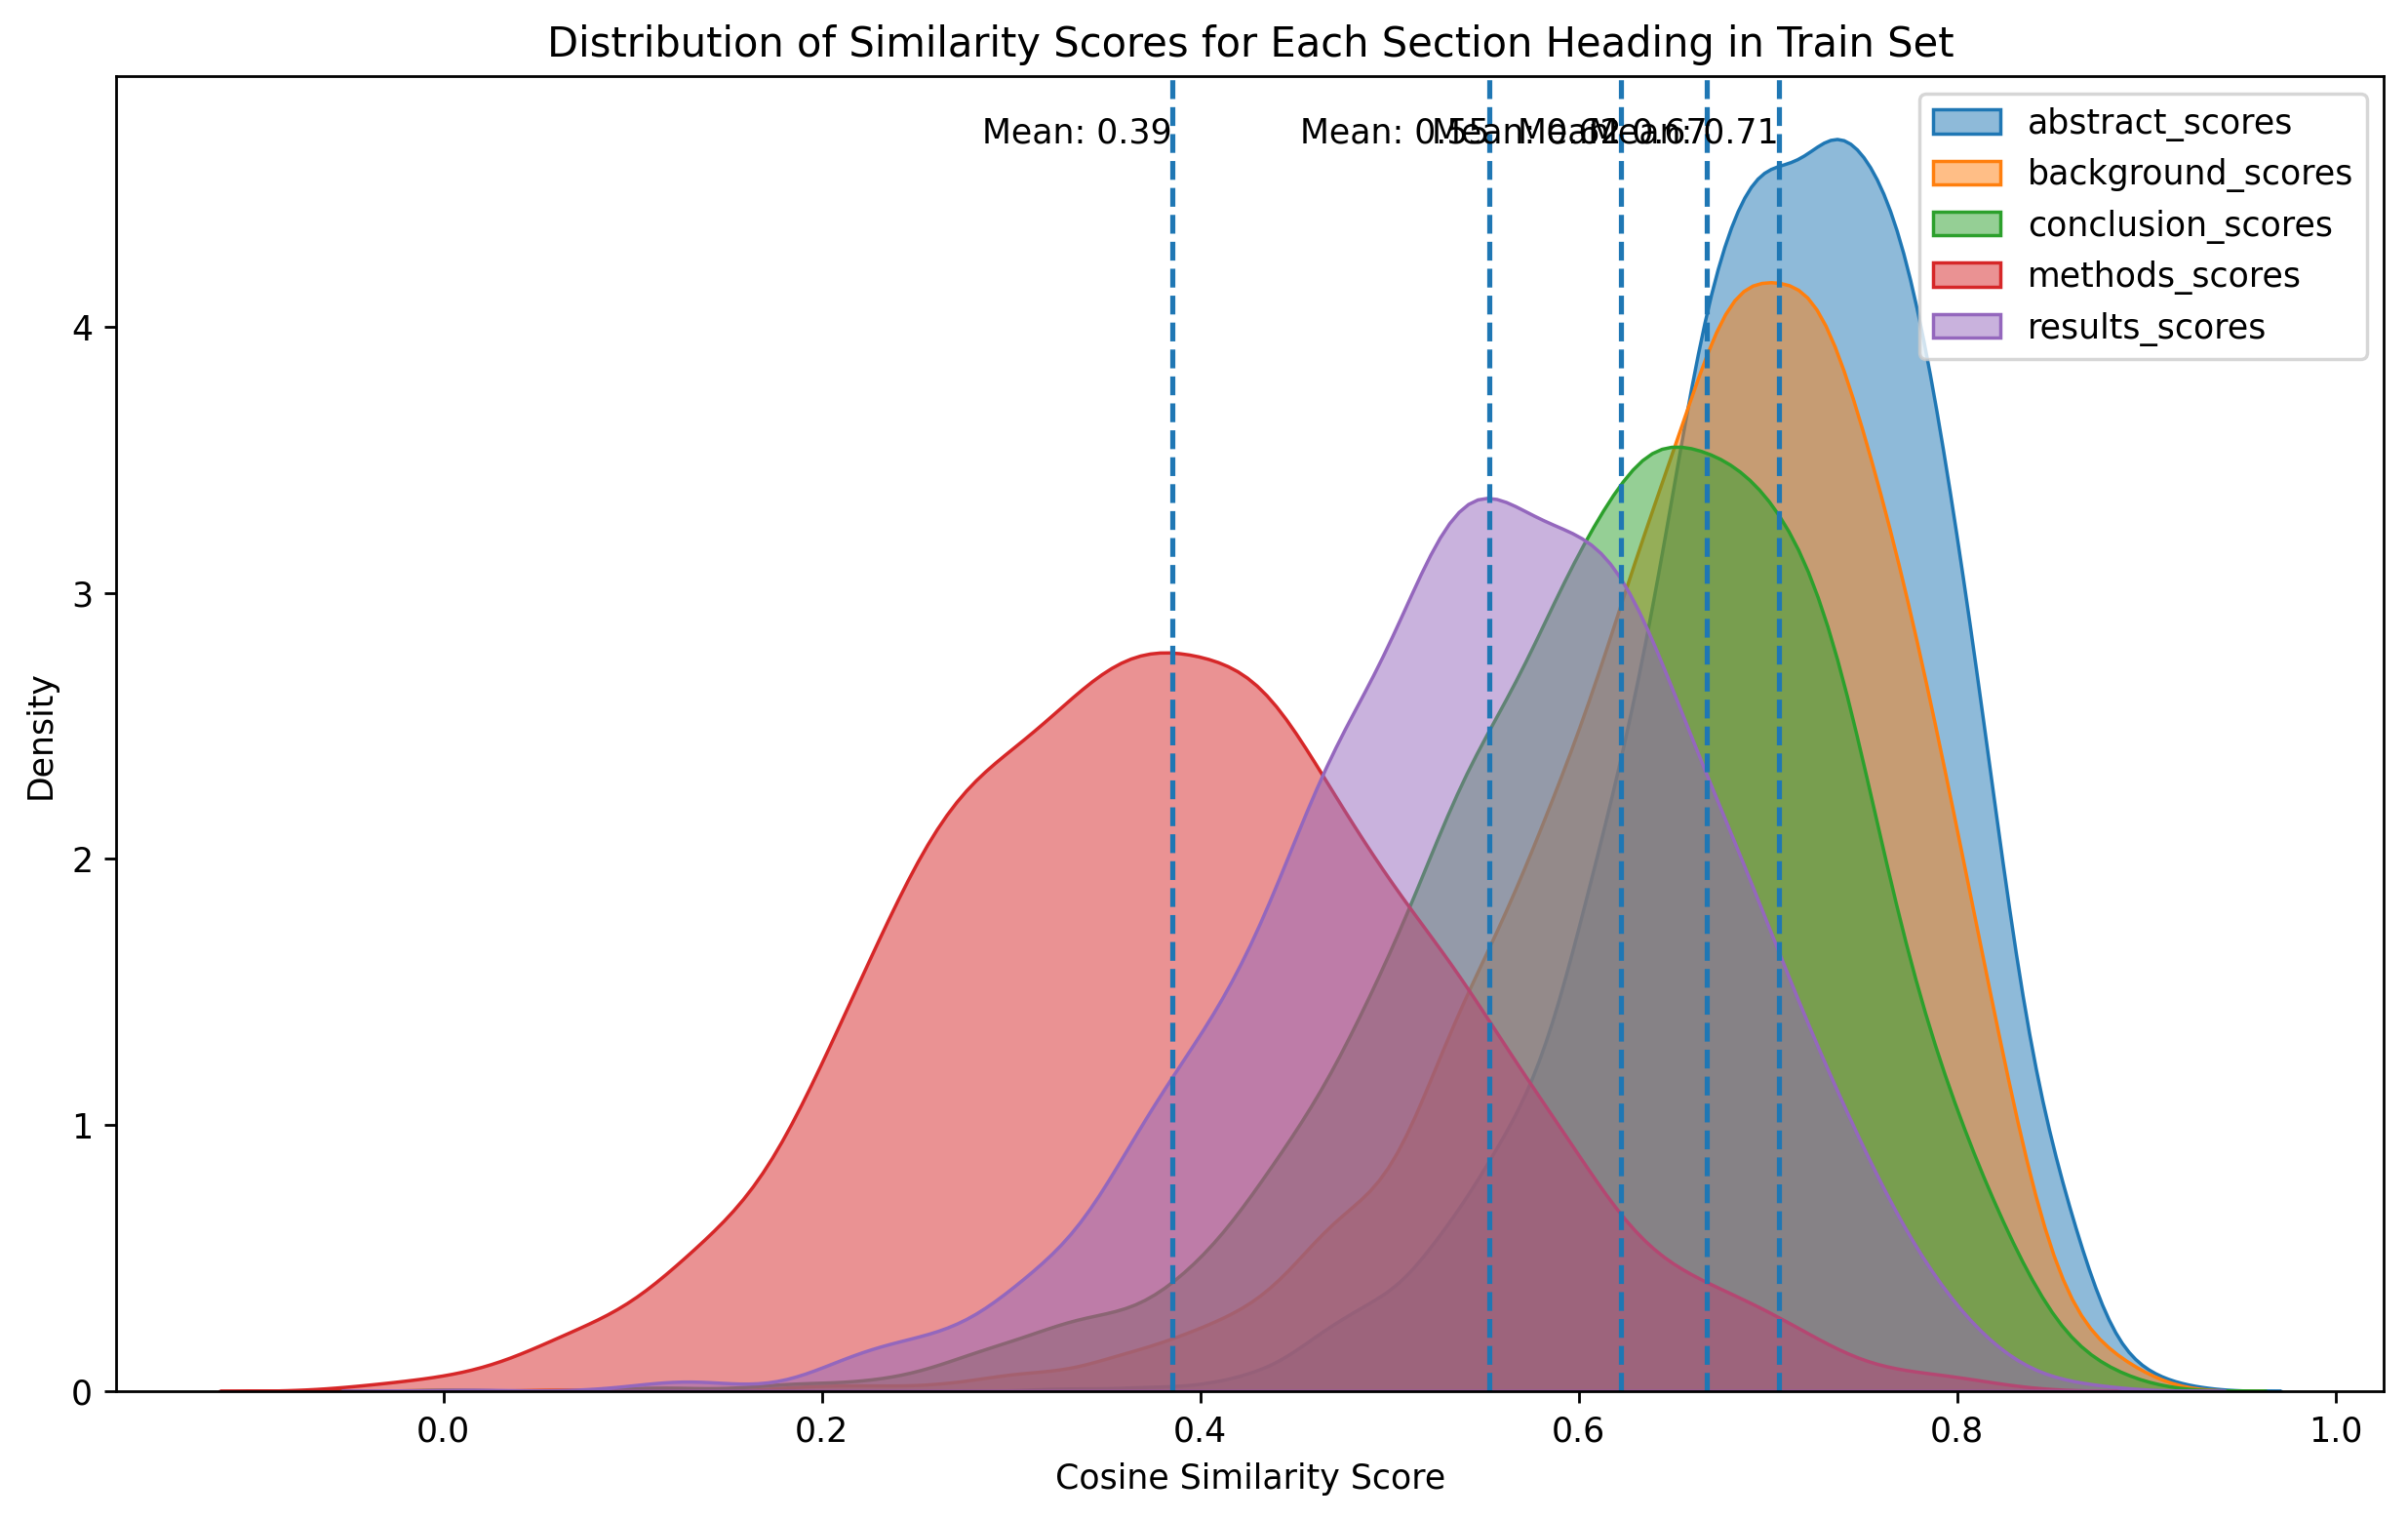

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

def read_numbers_from_file(file_path):
    with open(file_path, 'r') as file:
        numbers = [float(line.strip()) for line in file]
    return numbers


file_paths = ['/jet/home/zyou2/BioLaySumm/elife_similarity/abstract_scores.txt', 
              '/jet/home/zyou2/BioLaySumm/elife_similarity/background_scores.txt', 
              '/jet/home/zyou2/BioLaySumm/elife_similarity/conclusion_scores.txt',
              '/jet/home/zyou2/BioLaySumm/elife_similarity/methods_scores.txt',
              '/jet/home/zyou2/BioLaySumm/elife_similarity/results_scores.txt'
              ] 

numbers_dict = {os.path.splitext(os.path.basename(path))[0]: read_numbers_from_file(path) for path in file_paths}
# numbers_dict = {f'File {i+1}': read_numbers_from_file(path) for i, path in enumerate(file_paths)}

plt.figure(figsize=(12, 7), dpi=250)

for label, numbers in numbers_dict.items():
    sns.kdeplot(numbers, label=label, fill=True, common_norm=False, alpha=0.5)
    mean_value = sum(numbers) / len(numbers) 
    print(mean_value)
    plt.axvline(mean_value, linestyle='--', linewidth=1.5)
    plt.text(mean_value, plt.ylim()[1] * 0.95, f'Mean: {mean_value:.2f}', ha='right')

plt.title('Distribution of Similarity Scores for Each Section Heading in Train Set')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Density')
plt.legend()

plt.show()


In [12]:
### calculate the average length of text_a in train/test set that shaped in InputExample format
tokenizer = AutoTokenizer.from_pretrained("allenai/led-base-16384")
total_length = 0
num_items = 0
max_length = float('-inf')
min_length = float('inf')

# calculate articles
for article in elife_lay_sum_train:
    inputs = tokenizer(article, return_tensors="pt")
    # total_length += len(inputs["input_ids"][0])
    length = len(inputs["input_ids"][0])
    num_items += 1
    total_length += length
    if length > max_length:
        max_length = length
    if length < min_length:
        min_length = length

average_length = total_length / num_items

print("Average length of articles:", average_length)
print("Maximum length is:", max_length)
print("Minimum length is:", min_length)

Average length of articles: 437.1042337781868
Maximum length is: 786
Minimum length is: 206


In [ ]:
# plos train
plos_train_dataset = {'article': plos_article_train, 'abstract': plos_lay_sum_train}
plos_train_dataset = Dataset.from_dict(plos_train_dataset)

# val
plos_val_dataset = {'article': plos_article_val, 'abstract': plos_lay_sum_val}
plos_val_dataset = Dataset.from_dict(plos_val_dataset)

# train_dataset = train_dataset.select(range(500))
# val_dataset = val_dataset.select(range(10))

# map train data
train_dataset = plos_train_dataset.map(
    process_data_to_model_inputs,
    batched = True,
    batch_size = batch_size,
    remove_columns=["article", "abstract"]
)
# map val data
val_dataset = plos_val_dataset.map(
    process_data_to_model_inputs,
    batched = True,
    batch_size = batch_size,
    remove_columns=["article", "abstract"]
)

# the datasets should be converted into the PyTorch format
train_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
)
val_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
)



In [ ]:
led_model = AutoModelForSeq2SeqLM.from_pretrained("allenai/led-base-16384", gradient_checkpointing=True, use_cache=False)

# set generate hyperparameters
led_model.config.num_beams = 2
led_model.config.max_length = 512
led_model.config.min_length = 100
led_model.config.length_penalty = 2.0
led_model.config.early_stopping = True
led_model.config.no_repeat_ngram_size = 3

# Training
model_name = 'plos_led_1024'
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    output_dir=f"./{model_name}",
    logging_steps=5,
    eval_steps=10,
    save_steps=10,
    save_total_limit=2,
    gradient_accumulation_steps=4,
    num_train_epochs=1,
)

trainer = Seq2SeqTrainer(
    model=led_model,
    tokenizer=tokenizer,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()

In [27]:
plos_test_abstract = []

for sections in plos_article_test:
    article_sections = sections.split('\n')
    if article_sections:
        abstract = article_sections[0]
        plos_test_abstract.append(abstract)
        
print(plos_test_abstract[:2])

['Lung-resident ( LR ) mesenchymal stem and stromal cells ( MSCs ) are key elements of the alveolar niche and fundamental regulators of homeostasis and regeneration . We interrogated their function during virus-induced lung injury using the highly prevalent respiratory syncytial virus ( RSV ) which causes severe outcomes in infants . We applied complementary approaches with primary pediatric LR-MSCs and a state-of-the-art model of human RSV infection in lamb . Remarkably , RSV-infection of pediatric LR-MSCs led to a robust activation , characterized by a strong antiviral and pro-inflammatory phenotype combined with mediators related to T cell function . In line with this , following in vivo infection , RSV invades and activates LR-MSCs , resulting in the expansion of the pulmonary MSC pool . Moreover , the global transcriptional response of LR-MSCs appears to follow RSV disease , switching from an early antiviral signature to repair mechanisms including differentiation , tissue remodel

In [2]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
from utils import *

from transformers import(
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
)
from tqdm import tqdm
from datasets import Dataset
import os
import json
import random
from datasets import load_dataset, load_metric
import numpy as np
import nltk
from transformers import AutoTokenizer, LongT5ForConditionalGeneration
from transformers import AutoTokenizer, LongT5Model
from transformers import DataCollatorForSeq2Seq

random.seed(42)


tokenizer = AutoTokenizer.from_pretrained("google/long-t5-tglobal-large")

# tokenizer = AutoTokenizer.from_pretrained("Stancld/longt5-tglobal-large-16384-pubmed-3k_steps")
label_pad_token_id = tokenizer.pad_token_id
model = LongT5ForConditionalGeneration.from_pretrained("google/long-t5-tglobal-large")

encoder_max_length = 16384
decoder_max_length = 512
batch_size = 1

def process_data_to_model_inputs(batch):
    inputs = tokenizer(
        batch["article"],
        padding="max_length",
        truncation=True,
        max_length=encoder_max_length,
    )
    outputs = tokenizer(
        batch["abstract"],
        padding="max_length",
        truncation=True,
        max_length=decoder_max_length,
    )
    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask

    batch["global_attention_mask"] = len(batch["input_ids"]) * [
        [0 for _ in range(len(batch["input_ids"][0]))]
    ]

    batch["global_attention_mask"][0][0] = 1
    batch["labels"] = outputs.input_ids

    batch["labels"] = [
        [-100 if token == tokenizer.pad_token_id else token for token in labels]
        for labels in batch["labels"]
    ]

    return batch

from rouge import Rouge
rouge = Rouge()
# rouge = load_metric("rouge")
# the generation output, called pred.predictions as well as the gold label, called pred.label_ids.
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)
    rouge_output = rouge.get_scores(pred_str, label_str)[0]['rouge-2']
    
    # rouge_output = rouge.compute(
    #     predictions=pred_str, references=label_str, rouge_types=["rouge2"]
    # )["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output['p'], 4),
        "rouge2_recall": round(rouge_output['r'], 4),
        "rouge2_fmeasure": round(rouge_output['f'], 4),
    }


def load_data(dataset, datatype):

    data_folder = '/ocean/projects/cis230089p/zyou2/biolaysumm2024_data'
    data_path = os.path.join(data_folder, f'{dataset}_{datatype}.jsonl')
    lay_sum = []
    article =[]
    keyword = []
    headings = []
    id = []
    file = open(data_path, 'r')
    for line in (file.readlines()):
        dic = json.loads(line)
        article.append(dic['article'])
        keyword.append(dic['keywords'])
        headings.append(dic['headings'])
        id.append(dic['id'])
        lay_sum.append(dic['lay_summary'])
    
    return article, lay_sum, keyword, headings, id

# def load_test_data(dataset, datatype):

#     data_folder = '/ocean/projects/cis230089p/zyou2/biolaysumm2024_data'
    
#     data_path = os.path.join(data_folder, f'{dataset}_{datatype}.jsonl')
#     article =[]
#     keyword = []
#     headings = []
#     id = []
#     file = open(data_path, 'r')
#     for line in (file.readlines()):
#         dic = json.loads(line)
#         article.append(dic['article'])
#         keyword.append(dic['keywords'])
#         headings.append(dic['headings'])
#         id.append(dic['id'])
    
#     return article, keyword, headings, id

# import json

# ### PLOS
# # train
# # plos_article_train, plos_lay_sum_train, plos_keyword_train, plos_headings_train, plos_id_train = load_data('PLOS', 'train')
# # # val
# # plos_article_val, plos_lay_sum_val, plos_keyword_val, plos_headings_val, plos_id_val = load_data('PLOS', 'val')
# # # test
# # plos_article_test, plos_keyword_test, plos_headings_test, plos_id_test = load_test_data('PLOS', 'test')


### eLife
# train
elife_article_train, elife_lay_sum_train, elife_keyword_train, elife_headings_train, elife_id_train = load_data('eLife', 'train')
# val
elife_article_val, elife_lay_sum_val, elife_keyword_val, elife_headings_val, elife_id_val = load_data('eLife', 'val')
# test
# elife_article_test, elife_keyword_test, elife_headings_test, elife_id_test = load_test_data('eLife', 'test')


# elife train
elife_train_dataset = {'article': elife_article_train, 'abstract': elife_lay_sum_train}
elife_train_dataset = Dataset.from_dict(elife_train_dataset)

# val
elife_val_dataset = {'article': elife_article_val, 'abstract': elife_lay_sum_val}
elife_val_dataset = Dataset.from_dict(elife_val_dataset)

print("length of train and val datasets")
print(len(elife_train_dataset))
print(len(elife_val_dataset))


# map train data
train_dataset = elife_train_dataset.map(
    process_data_to_model_inputs,
    batched = True,
    batch_size = batch_size,
    remove_columns=["article", "abstract"]
)
# map val data
val_dataset = elife_val_dataset.map(
    process_data_to_model_inputs,
    batched = True,
    batch_size = batch_size,
    remove_columns=["article", "abstract"]
)

# # the datasets should be converted into the PyTorch format
train_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
)
val_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
)


# # set generate hyperparameters
# led_model.config.num_beams = 2
# led_model.config.max_length = 512
# led_model.config.min_length = 100
# led_model.config.length_penalty = 2.0
# led_model.config.early_stopping = True
# led_model.config.no_repeat_ngram_size = 3

# Training
model_name = 'longt5_elife'
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=False,
    generation_max_length=512,
    output_dir=f"/jet/home/zyou2/BioLaySumm/LongT5-fine-tuning/{model_name}",
    logging_steps=100,
    save_total_limit=2,
    learning_rate=2e-5,
    weight_decay=0.01,
    num_train_epochs=1,
    load_best_model_at_end=True,
)

print("start training...")

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, label_pad_token_id=label_pad_token_id, pad_to_multiple_of=None)

trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
)

trainer.train()
trainer.model.save_pretrained(os.path.join(f"/jet/home/zyou2/BioLaySumm/LongT5-fine-tuning/{model_name}", 'checkpoint-best'))
result["predicted_abstract"] = trainer.predict(test_dataset=val_dataset)
decoded_preds = tokenizer.batch_decode(result.predicted_abstract, skip_special_tokens=True)

with open('/jet/home/zyou2/BioLaySumm/LongT5-fine-tuning/longt5_val_predicted_abstracts.txt', 'w') as file:
    for abstract in decoded_preds:
        file.write(abstract + '\n')
        
print("finished writing")

# trainer.evaluate()

In [6]:
import json

with open('/ocean/projects/cis230089p/zyou2/BioNLP/extract_aug_data/elife_val_old_summ_level_embedding.json', 'r') as f:
    data = json.load(f)
print(len(data))

241


In [7]:
from transformers import AutoTokenizer

train_list = []
tokenizer = AutoTokenizer.from_pretrained("allenai/led-base-16384")
count = 0
for chunk in data: 
    input_ids = tokenizer(chunk, return_tensors="pt", truncation=True, padding=True).input_ids
    train_list.append(input_ids.shape[1])
    count += input_ids.shape[1]
    # print(input_ids.shape[1])
print(len(train_list))

ave = count / len(data)
print(ave)

241
1973.0663900414938
